# Torch Datasets

In [1]:
# Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from PIL import Image
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root='data', train=True, download=True)
print("Length of training set: ", len(mnist_train))
print("Type of training set: ", type(mnist_train))
print("Type of element: ", type(mnist_train[0]))
print("Type of element[0], element[1]: ", type(mnist_train[0][0]), type(mnist_train[0][1]))
print("=> MNIST is subscriptable as MNIST.__getitem__(index: int) -> Tuple[PIL.Image.Image, int]")

# As a PIL image
mnist_train[0][0].show()
print(mnist_train[0][1])

Length of training set:  60000
Type of training set:  <class 'torchvision.datasets.mnist.MNIST'>
Type of element:  <class 'tuple'>
Type of element[0], element[1]:  <class 'PIL.Image.Image'> <class 'int'>
=> MNIST is subscriptable as MNIST.__getitem__(index: int) -> Tuple[PIL.Image.Image, int]


5


Length of training set:  60000
Type of training set:  <class 'torchvision.datasets.mnist.MNIST'>
Type of element:  <class 'tuple'>
Type of element[0], element[1]:  <class 'torch.Tensor'> <class 'int'>
torch.Size([1, 28, 28])
Default image shape: torch.Size([1, 28, 28])
Reshaped image shape: torch.Size([28, 28])


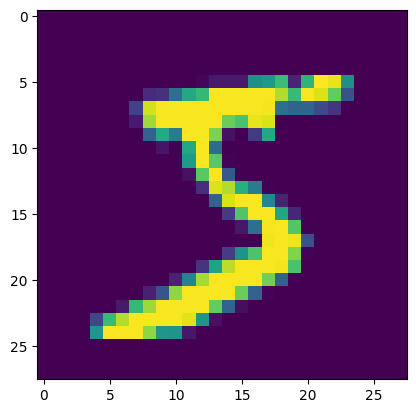

In [3]:
# Hence it is necessary to convert it to a tensor. This can be done by transforming it while loading as follows
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

print("Length of training set: ", len(mnist_train))
print("Type of training set: ", type(mnist_train))
print("Type of element: ", type(mnist_train[0]))
print("Type of element[0], element[1]: ", type(mnist_train[0][0]), type(mnist_train[0][1]))
print(mnist_train[0][0].shape)

# Lets make it back into a PIL image and display
print("Default image shape:", mnist_train[0][0].shape)
image = mnist_train[0][0].reshape(28, 28)
print("Reshaped image shape:", image.shape)
plt.imshow(image)

# Torch DataLoaders
The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True) #Not subscriptable

print("Length of training set: ", len(mnist_train))
print("Length of train_loader: ", len(train_loader))
print("Type of train_loader: ", type(train_loader))
print("Type of element: ", type(train_loader))

# Lets see what the first element of the train_loader looks like

train_iter = iter(train_loader)
images, labels = train_iter.__next__()
print("Type of the minibatch of images: {} => Shape: {}".format(type(images), images.shape))
print("Type of the minibatch of labels: {} => Shape: {}".format(type(labels), labels.shape))

Length of training set:  60000
Length of train_loader:  600
Type of train_loader:  <class 'torch.utils.data.dataloader.DataLoader'>
Type of element:  <class 'torch.utils.data.dataloader.DataLoader'>
Type of the minibatch of images: <class 'torch.Tensor'> => Shape: torch.Size([100, 1, 28, 28])
Type of the minibatch of labels: <class 'torch.Tensor'> => Shape: torch.Size([100])


# Logistic Model

In [5]:
W = torch.randn(784, 10)/np.sqrt(784) # Xavier initialization
W.requires_grad_()
b = torch.zeros(10, requires_grad=True)


def linear(x: torch.Tensor):
    return x@W + b

x = images.view(-1, 28*28) # Equivalent to x = images.reshape(-1, 28*28)
print("Shape of x: ", x.shape)
y = linear(x)
print("Value of y[0]: ", y[0])
print("Shape of y: ", y.shape)

def softmax1(y: torch.Tensor):
    return torch.exp(y) / torch.sum(torch.exp(y), dim=1, keepdim=True)

import torch.nn.functional as F
def softmax2(y: torch.Tensor):
    return F.softmax(y, dim=1)

z = softmax2(y)
print("Shape of z: ", z.shape)
print("Value of z[0]: ", y[0])


Shape of x:  torch.Size([100, 784])
Value of y[0]:  tensor([ 0.2319,  0.5280,  0.1843,  0.0442,  0.6704, -0.0227, -0.5230, -0.1828,
         0.4210,  0.3666], grad_fn=<SelectBackward0>)
Shape of y:  torch.Size([100, 10])
Shape of z:  torch.Size([100, 10])
Value of z[0]:  tensor([ 0.2319,  0.5280,  0.1843,  0.0442,  0.6704, -0.0227, -0.5230, -0.1828,
         0.4210,  0.3666], grad_fn=<SelectBackward0>)


# Defining Loss

## Cross Entropy Loss

Refer to [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy) in Shannon's Information Theory.
* [StatQuest](https://youtu.be/6ArSys5qHAU) has a good explanation for this
* Say we have a model that predicts whether a blue, yellow or red ball is being selected.
* Lets calculate amount of information the model gives us about the ball.
  * Suppose a blue ball is selected.
    * The model says the probability the selected ball is blue is $q_b$
    * Hence, the amount of information the model gives us about the ball is $-log(q_b)$ which corresponds to how surprised a person would be if they found out the ball was blue.
      * If $q_b$ is high, then the person would not be surprised at all. This means the model has done a good job at predicting the ball is blue.
      * If $q_b$ is low, then the person would be very surprised. This means the model has done a bad job at predicting the ball is blue.
      * We should be surprise if reality is not what we expect.
  * Generalising, considering the actual probability that blue, yellow or red ball is selected is $p_b, p_y, p_r$ respectively, the amount of information the model gives us about the ball is $-p_b log(q_b) - p_y log(q_y) - p_r log(q_r) = -\sum p_i log(q_i)$
  * This shows that cross-entropy can be thought of as how surprised you would be if you found out the model's prediction was wrong.

Explaining exactly what the cross-entropy represents goes slightly beyond the scope of this course, but you can think of it as a way of quantifying how far apart one distribution $y'$ is from another $y$.

\begin{align}
H_{y'}(y)=-\sum_i y'_i \text{log}(y_i)
\end{align}

In our case,  𝑦
  is the set of probabilities predicted by the model ( 𝑝𝑦
  above);  𝑦′
  is the target distribution. What is the target distribution? It's the true label, which is what we wanted the model to predict.

Cross-entropy not only captures how correct (max probability corresponds to the right answer) the model's answers are, it also accounts for how confident (high confidence in correct answers) they are. This encourages the model to produce very high probabilities for correct answers while driving down the probabilities for the wrong answers, instead of merely being satisfied with it being the argmax.

In [6]:
def cross_entropy1(labels: torch.Tensor, y: torch.Tensor):
    return torch.mean(-torch.log(y[range(z.shape[0]), labels])) # Selecting only the appropriate columns for each rows based on labels

print("Shape of z: ", z.shape)
z_filtered = z[range(z.shape[0]), labels]
print("Shape of z_filtered: ", z_filtered.shape)
print("Value of z_filtered: ", z_filtered)

def cross_entropy2(labels: torch.Tensor, y: torch.Tensor):
    return F.cross_entropy(y, labels)

Shape of z:  torch.Size([100, 10])
Shape of z_filtered:  torch.Size([100])
Value of z_filtered:  tensor([0.0834, 0.0911, 0.0635, 0.1230, 0.2095, 0.1453, 0.0941, 0.0909, 0.0964,
        0.0939, 0.0931, 0.0603, 0.0981, 0.1056, 0.0661, 0.0934, 0.1286, 0.0944,
        0.1648, 0.0937, 0.0463, 0.1206, 0.1229, 0.1251, 0.0524, 0.1194, 0.0894,
        0.1973, 0.1938, 0.0657, 0.1197, 0.0865, 0.1691, 0.0905, 0.1055, 0.1127,
        0.0964, 0.0971, 0.1210, 0.0860, 0.1028, 0.0752, 0.1022, 0.1374, 0.0894,
        0.1579, 0.0738, 0.0845, 0.0765, 0.1517, 0.1399, 0.1237, 0.0963, 0.1635,
        0.0811, 0.1117, 0.0714, 0.0762, 0.1375, 0.0904, 0.1057, 0.1072, 0.0874,
        0.1486, 0.1029, 0.0957, 0.0743, 0.0799, 0.0969, 0.1159, 0.1134, 0.1204,
        0.1384, 0.1135, 0.1436, 0.1126, 0.0999, 0.1325, 0.0625, 0.1333, 0.1679,
        0.0826, 0.1291, 0.0989, 0.1189, 0.0878, 0.0864, 0.1272, 0.0579, 0.1281,
        0.0595, 0.0916, 0.1121, 0.1041, 0.1182, 0.0788, 0.1864, 0.0769, 0.1394,
        0.1638], grad_f

In [7]:
# Lessons on range(n) as index 

## Why range(z.shape[0])?
a = torch.arange(0, 16, 1).view(4,4)
print(a)

# Slices and ellipsis keeps whole rows, only selects certain columns
print("With Slice:", a[:, [1, 2]])
print("With Ellipsis:", a[..., [1, 2]])

# Range row by row (array needs to be same length as rows)
# There is some coupling between riows and columns
print("With Range:", a[range(a.shape[0]), [0, 1, 2, 3]])

# Array selects certain rows and certain columns
print("With Array:", a[[0, 2], [1, 3]])

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
With Slice: tensor([[ 1,  2],
        [ 5,  6],
        [ 9, 10],
        [13, 14]])
With Ellipsis: tensor([[ 1,  2],
        [ 5,  6],
        [ 9, 10],
        [13, 14]])
With Range: tensor([ 0,  5, 10, 15])
With Array: tensor([ 1, 11])


# Backward pass and optimizers

In [8]:
# What if no gradient is required?
try:
    test_input = torch.tensor([1.,1.,1.,1.]).view(1, 4)
    test_weights = torch.tensor([1.,2.,3.,4.], requires_grad=False).view(4, 1)
    test_labels = torch.tensor([0.5]).view(1,1)
    closs = cross_entropy2(test_labels, F.softmax(test_input@test_weights))
    closs.backward()
except RuntimeError as e:
    print("RuntimeError:", e)


# In 1 iteration
optimizer = torch.optim.SGD([W, b], lr=0.1)
print("Type of optimizer:", type(optimizer))
# print("Value of optimizer:", optimizer)
print("Type of optimizer.param_groups:", type(optimizer.param_groups))
# print("Value of optimizer.param_groups:", optimizer.param_groups)

print("Current gradient:", b.grad)
optimizer.zero_grad() # Zero out the gradient of the parameters. Parameters have gradients attached to it.
print("optimizer.zero_grad() wipes gradient:", b.grad)

print("Shape of images", images.shape)
x = images.view(-1, 28*28)
print("Shape of x: ", x.shape)

y = linear(x)
z = softmax2(y)
print("z[0]:", z[0])

loss = cross_entropy2(labels, z) # labels is a tensor of shape (100, )
print("loss:", loss)

loss.backward() # Compute the gradient of the loss for each parameter. Load these gradients into the .grad attribute of each parameter
print("New gradients:", b.grad)

optimizer.step() # Update the parameters using the gradients in the .grad attribute

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
Type of optimizer: <class 'torch.optim.sgd.SGD'>
Type of optimizer.param_groups: <class 'list'>
Current gradient: None
optimizer.zero_grad() wipes gradient: None
Shape of images torch.Size([100, 1, 28, 28])
Shape of x:  torch.Size([100, 784])
z[0]: tensor([0.1006, 0.1353, 0.0960, 0.0834, 0.1560, 0.0780, 0.0473, 0.0665, 0.1216,
        0.1152], grad_fn=<SelectBackward0>)
loss: tensor(2.2946, grad_fn=<NllLossBackward0>)


/tmp/ipykernel_1850/937945389.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  closs = cross_entropy2(test_labels, F.softmax(test_input@test_weights))


New gradients: tensor([ 0.0012, -0.0042, -0.0018,  0.0034, -0.0029,  0.0037, -0.0029,  0.0009,
         0.0038, -0.0012])


In [9]:
from tqdm import tqdm # Make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you’re done!

for images, labels in tqdm(train_loader):
    optimizer.zero_grad() # Reset the gradients
    x = images.view(-1, 28*28)
    y = linear(x)
    z = softmax2(y)
    loss = cross_entropy2(labels, z)
    loss.backward()
    optimizer.step()

100%|██████████| 600/600 [00:06<00:00, 99.39it/s] 


# Testing the model

In [10]:
corect = 0
total = len(mnist_test)

test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

with torch.no_grad(): # Prevents any gradient calculations
    for images, labels in tqdm(test_loader):
        x = images.view(-1, 28*28)
        y = linear(x)
        z = softmax2(y)
        predictions = torch.argmax(z, dim=1)
        corect += torch.sum((predictions == labels).float())

print('Test accuracy:', corect/total)

100%|██████████| 100/100 [00:00<00:00, 104.02it/s]

Test accuracy: tensor(0.8384)


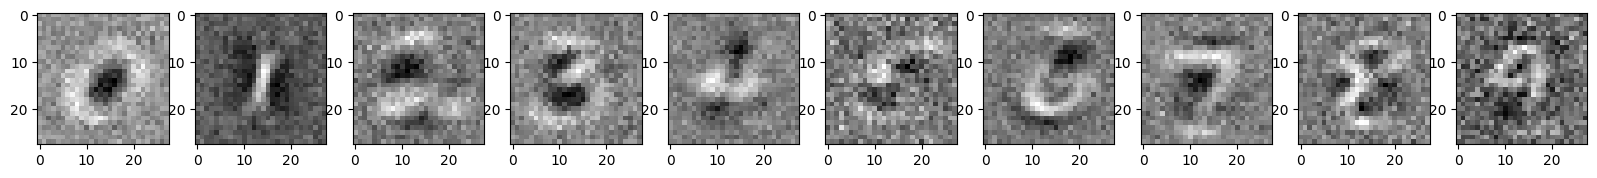

In [11]:
# Lets see the weights

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for digit in range(10):
    ax[digit].imshow(W[:, digit].detach().view(28, 28), cmap='gray')

# OOP Refactor

In [15]:
from torch import nn

class MNIST_Logistic_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
    
    def forward(self, x):
        return self.lin(x)
    
model = MNIST_Logistic_Regression()
y = model(x)
print("Model:", model)
print("Parameters:", list(model.parameters()))
print("Output shape:", y.shape)

criterion = nn.CrossEntropyLoss() # Same as criterion = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for images, labels in tqdm(train_loader):
    optimizer.zero_grad()
    x = images.view(-1, 28*28)
    y = model(x)
    loss = criterion(y, labels)
    loss.backward()
    optimizer.step()

correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for images, labels in tqdm(test_loader):
        # Forward pass
        x = images.view(-1, 28*28)
        y = model(x)
        
        predictions = torch.argmax(y, dim=1)
        correct += torch.sum((predictions == labels).float())
    
print('Test accuracy: {}'.format(correct/total))




Model: MNIST_Logistic_Regression(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)
Parameters: [Parameter containing:
tensor([[ 0.0035, -0.0302,  0.0026,  ...,  0.0022, -0.0200,  0.0294],
        [ 0.0220,  0.0013, -0.0357,  ...,  0.0100,  0.0270,  0.0292],
        [-0.0066, -0.0065, -0.0002,  ...,  0.0325, -0.0004,  0.0339],
        ...,
        [-0.0194, -0.0067,  0.0033,  ..., -0.0346,  0.0109,  0.0041],
        [ 0.0320, -0.0225,  0.0231,  ...,  0.0091, -0.0268, -0.0228],
        [-0.0297, -0.0295, -0.0316,  ...,  0.0178,  0.0271,  0.0213]],
       requires_grad=True), Parameter containing:
tensor([ 0.0245, -0.0193,  0.0339, -0.0154, -0.0252,  0.0325,  0.0293,  0.0071,
         0.0279,  0.0306], requires_grad=True)]
Output shape: torch.Size([100, 10])


100%|██████████| 100/100 [00:01<00:00, 99.54it/s]

Test accuracy: 0.902400016784668


### Tutorials:
* [Pytorch Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)
* [Pytorch Datasets](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

### References:
* [Documentation for `datasets.MNIST()` function](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)
* [Documentation for `transform.toTensor()` function](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
* [Documentation for `plt.imshow()` function](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)
* [Documentation for `Tensor.view(*shape)` function](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html)
* [Documentation for `F.softmax()` function](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html)
* [Documentation for `torch.Optim` package](https://pytorch.org/docs/stable/optim.html)
* [Documentation for `torch.no_grad()` function](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

